In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
file_path = "/content/drive/MyDrive/Dataset Idealista/pisosBarcelona-21-04-2025-clean.csv"
df = pd.read_csv(file_path, encoding='latin1')

In [4]:
import pandas as pd

# Convertir fechas si hay alguna en el dataset
date_columns = ['publicationDate', 'updatedAt']  # Ajustar si hay columnas de fecha en el dataset
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Convertir números a enteros donde aplique
int_columns = ['numPhotos', 'rooms', 'bathrooms', 'floor']
for col in int_columns:
    if col in df.columns:
        # Asegurarse de que pd.NA o np.nan se manejen antes de convertir a int
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # Imputar NaN con 0 antes de convertir a entero
        if df[col].isnull().any():
            df[col].fillna(0, inplace=True)
        # Convertir a tipo entero nullable si es necesario o a int si no hay nulos
        if pd.api.types.is_numeric_dtype(df[col]) and df[col].notnull().all():
             df[col] = df[col].astype(int)
        else: # Si aún quedan nulos o no es numérico, dejar como float o object
             pass # O maneja otros casos si es necesario

# Convertir precios y métricas económicas a float
float_columns = ['price', 'size', 'priceByArea']
for col in float_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Eliminar filas donde el precio es NaN, ya que es la variable objetivo
if 'price' in df.columns:
    df.dropna(subset=['price'], inplace=True)

print("Tipos de datos después de la conversión y limpieza de NaNs en 'price':")
print(df.dtypes)
print(f"\nFilas restantes: {len(df)}")

Tipos de datos después de la conversión y limpieza de NaNs en 'price':
propertyCode                  int64
numPhotos                     int64
floor                         int64
price                       float64
priceInfo                    object
propertyType                 object
operation                    object
size                        float64
exterior                     object
rooms                         int64
bathrooms                     int64
address                      object
province                     object
municipality                 object
district                     object
country                      object
neighborhood                 object
latitude                    float64
longitude                   float64
url                          object
hasVideo                       bool
status                       object
newDevelopment                 bool
hasLift                      object
priceByArea                 float64
hasPlan                      

<ipython-input-4-b4a2936d0703>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Copia del dataset original limpio
df_clean = df.copy()

# 1️⃣ Seleccionar columnas numéricas relevantes (SIN escalar aún)
numerical_cols = [
    "size", "rooms", "bathrooms", "latitude", "longitude", "numPhotos"
]

# 2️⃣ Seleccionar columnas categóricas relevantes (SIN 'geo_cluster' todavía)
#    También se imputarán NaNs aquí antes de la división
categorical_cols_initial = [
    "propertyType", "operation", "floor", "exterior", "province", "municipality",
    "district", "neighborhood", "status", "hasLift", "newDevelopment"
]

# Imputar valores faltantes en variables categóricas originales
# NOTA: Convertir 'floor' a string ANTES de fillna si es numérico para evitar problemas de tipo
if 'floor' in df_clean.columns and pd.api.types.is_numeric_dtype(df_clean['floor']):
    df_clean['floor'] = df_clean['floor'].astype(str)

df_clean["floor"].fillna("unknown", inplace=True)
df_clean["exterior"].fillna("unknown", inplace=True)
df_clean["hasLift"].fillna("unknown", inplace=True)
df_clean["district"].fillna("unknown", inplace=True)
df_clean["neighborhood"].fillna("unknown", inplace=True)
# Asegurarse de que no haya NaNs en otras categóricas seleccionadas
for col in categorical_cols_initial:
     if df_clean[col].isnull().any():
           print(f"Advertencia: NaN encontrado en {col}, rellenando con 'unknown'")
           df_clean[col].fillna("unknown", inplace=True)
     # Convertir todas las categóricas a string para consistencia
     df_clean[col] = df_clean[col].astype(str)


# 3️⃣ Separar variables predictoras (X) y variable objetivo (y)
#    Usamos solo las columnas seleccionadas inicialmente
cols_to_use = numerical_cols + categorical_cols_initial
X = df_clean[cols_to_use]
y = df_clean["price"]

# 4️⃣ Dividir 80% interpolación y 20% extrapolación (SIN shuffle)
X_interpolation, X_extrapolation, y_interpolation, y_extrapolation = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42 # random_state aquí no afecta por shuffle=False, pero es buena práctica
)

# 5️⃣ Dentro de la interpolación, dividir 80% train y 20% test (CON shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X_interpolation, y_interpolation, test_size=0.2, random_state=42 # Shuffle por defecto es True
)

print("✅ Datos divididos en conjuntos de entrenamiento, prueba y extrapolación.")
print(f"Tamaño Entrenamiento: {X_train.shape}, Tamaño Prueba: {X_test.shape}, Tamaño Extrapolación: {X_extrapolation.shape}")

Advertencia: NaN encontrado en status, rellenando con 'unknown'
✅ Datos divididos en conjuntos de entrenamiento, prueba y extrapolación.
Tamaño Entrenamiento: (5425, 17), Tamaño Prueba: (1357, 17), Tamaño Extrapolación: (1696, 17)


<ipython-input-5-9d20c47b0a6c>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean["floor"].fillna("unknown", inplace=True)
<ipython-input-5-9d20c47b0a6c>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

Clustering

🌍 Iniciando Clustering Geográfico (K-Means)...
Calculando inertia para k en range(5, 26)...


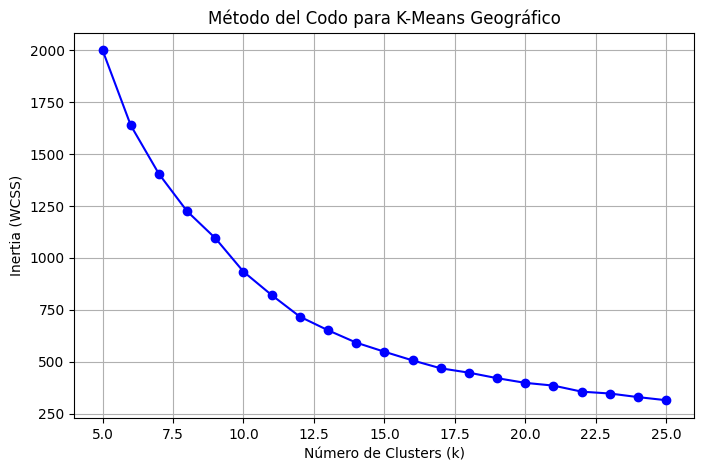

Se eligió k = 15 para el clustering (ajusta 'chosen_k' si es necesario).


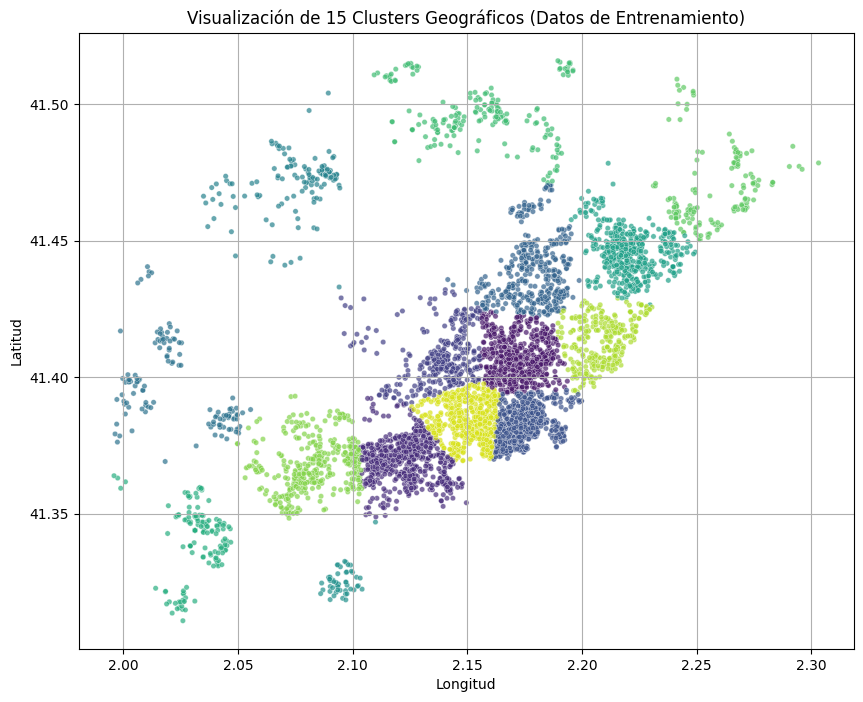

✅ Característica 'geo_cluster' añadida. Tipo: object


In [6]:
# --- START: Clustering Geográfico Section ---
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Asegúrate de importar numpy

print("🌍 Iniciando Clustering Geográfico (K-Means)...")

# 1. Seleccionar características para clustering
cluster_features = ['latitude', 'longitude']
# Asegurarse de que no haya NaNs en las coordenadas antes de escalar
if X_train[cluster_features].isnull().any().any():
    print("¡Advertencia! Valores NaN encontrados en coordenadas de entrenamiento. Rellenando con la media.")
    X_train[cluster_features] = X_train[cluster_features].fillna(X_train[cluster_features].mean())
if X_test[cluster_features].isnull().any().any():
    print("¡Advertencia! Valores NaN encontrados en coordenadas de prueba. Rellenando con la media del entrenamiento.")
    X_test[cluster_features] = X_test[cluster_features].fillna(X_train[cluster_features].mean()) # Usar media de train
if X_extrapolation[cluster_features].isnull().any().any():
    print("¡Advertencia! Valores NaN encontrados en coordenadas de extrapolación. Rellenando con la media del entrenamiento.")
    X_extrapolation[cluster_features] = X_extrapolation[cluster_features].fillna(X_train[cluster_features].mean()) # Usar media de train

X_train_coords = X_train[cluster_features].copy()
X_test_coords = X_test[cluster_features].copy()
X_extrapolation_coords = X_extrapolation[cluster_features].copy()

# 2. Escalar características (importante para K-Means)
coord_scaler = StandardScaler()
X_train_coords_scaled = coord_scaler.fit_transform(X_train_coords)
# Nota: Usamos el scaler ajustado en train para transformar test y extrapolation
X_test_coords_scaled = coord_scaler.transform(X_test_coords)
X_extrapolation_coords_scaled = coord_scaler.transform(X_extrapolation_coords)

# 3. Encontrar un número razonable de clusters (k) usando el método del codo
inertia = []
# Reducir rango si tarda mucho, o aumentar si el codo no es claro
k_range = range(5, 26) # Probar de 5 a 25 clusters
print(f"Calculando inertia para k en {k_range}...")
for k in k_range:
    kmeans_elbow = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_elbow.fit(X_train_coords_scaled)
    inertia.append(kmeans_elbow.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Método del Codo para K-Means Geográfico')
plt.grid(True)
plt.show()

# 4. Elegir k (basado en el gráfico del codo - busca donde la curva se "aplana")
#    Este valor es subjetivo, ajústalo después de ver el gráfico.
#    Empecemos con un valor tentativo, por ejemplo, k=15
chosen_k = 15 # <<<--- AJUSTA ESTE VALOR BASADO EN EL GRÁFICO DEL CODO
print(f"Se eligió k = {chosen_k} para el clustering (ajusta 'chosen_k' si es necesario).")

# 5. Entrenar K-Means con el k elegido en los datos de entrenamiento
kmeans = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
kmeans.fit(X_train_coords_scaled)

# 6. Asignar clusters a todos los conjuntos de datos
#    Usamos .copy() para evitar SettingWithCopyWarning más adelante si es necesario
X_train = X_train.copy()
X_test = X_test.copy()
X_extrapolation = X_extrapolation.copy()
X_train['geo_cluster'] = kmeans.predict(X_train_coords_scaled)
X_test['geo_cluster'] = kmeans.predict(X_test_coords_scaled)
X_extrapolation['geo_cluster'] = kmeans.predict(X_extrapolation_coords_scaled)

# Convertir la nueva columna a tipo 'string' para que pd.get_dummies la trate correctamente
X_train['geo_cluster'] = X_train['geo_cluster'].astype(str)
X_test['geo_cluster'] = X_test['geo_cluster'].astype(str)
X_extrapolation['geo_cluster'] = X_extrapolation['geo_cluster'].astype(str)


# 7. (Opcional pero recomendado) Visualizar los clusters geográficos en el mapa
plt.figure(figsize=(10, 8))
# Usar una paleta discreta si k no es demasiado grande
palette = sns.color_palette("viridis", chosen_k) if chosen_k <= 20 else sns.color_palette("hsv", chosen_k)
sns.scatterplot(x=X_train['longitude'], y=X_train['latitude'], hue=X_train['geo_cluster'],
                palette=palette, s=15, legend=None, alpha=0.7)
plt.title(f'Visualización de {chosen_k} Clusters Geográficos (Datos de Entrenamiento)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(True)
plt.show()

print(f"✅ Característica 'geo_cluster' añadida. Tipo: {X_train['geo_cluster'].dtype}")

# --- END: Clustering Geográfico Section ---

XGBOOST


⚙️ Iniciando Preprocesamiento Final (Escalado y One-Hot Encoding)...
Dimensiones finales: Train=(5425, 239), Test=(1357, 239), Extrapolation=(1696, 239)
✅ Preprocesamiento Final Completado.

🔥 Calculando importancia con Lasso...
Importancia Lasso calculada.

⏳ Iniciando Búsqueda de Hiperparámetros para Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.277e+14, tolerance: 1.612e+11
  model = cd_fast.enet_coordinate_descent(



Búsqueda de Hiperparámetros completada en 1111.92 segundos.
🏆 Mejores Hiperparámetros encontrados (RF): {'max_depth': np.int64(29), 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 466}
🏅 Mejor R² score en CV durante la búsqueda (RF): 0.7907

🔥 Calculando importancia con Random Forest (tuneado)...

📊 Agrupando Importancia de Características...

📊 Importancia de las Variables (Agrupadas por Categoría - Lasso + Tuned RF):
           Feature    Importance
10        district  5.126769e+06
11    neighborhood  4.615050e+06
9     municipality  3.650879e+06
7            floor  2.818375e+06
15     geo_cluster  1.933332e+06
6     propertyType  2.551615e+05
3         latitude  1.130737e+05
2        bathrooms  1.033555e+05
12          status  3.909608e+04
1            rooms  2.779096e+04
4        longitude  2.305940e+04
8         exterior  2.167297e+04
0             size  1.915066e+04
13         hasLift  1.057295e+04
14  newDevelopment  6.922686e+03
5        num

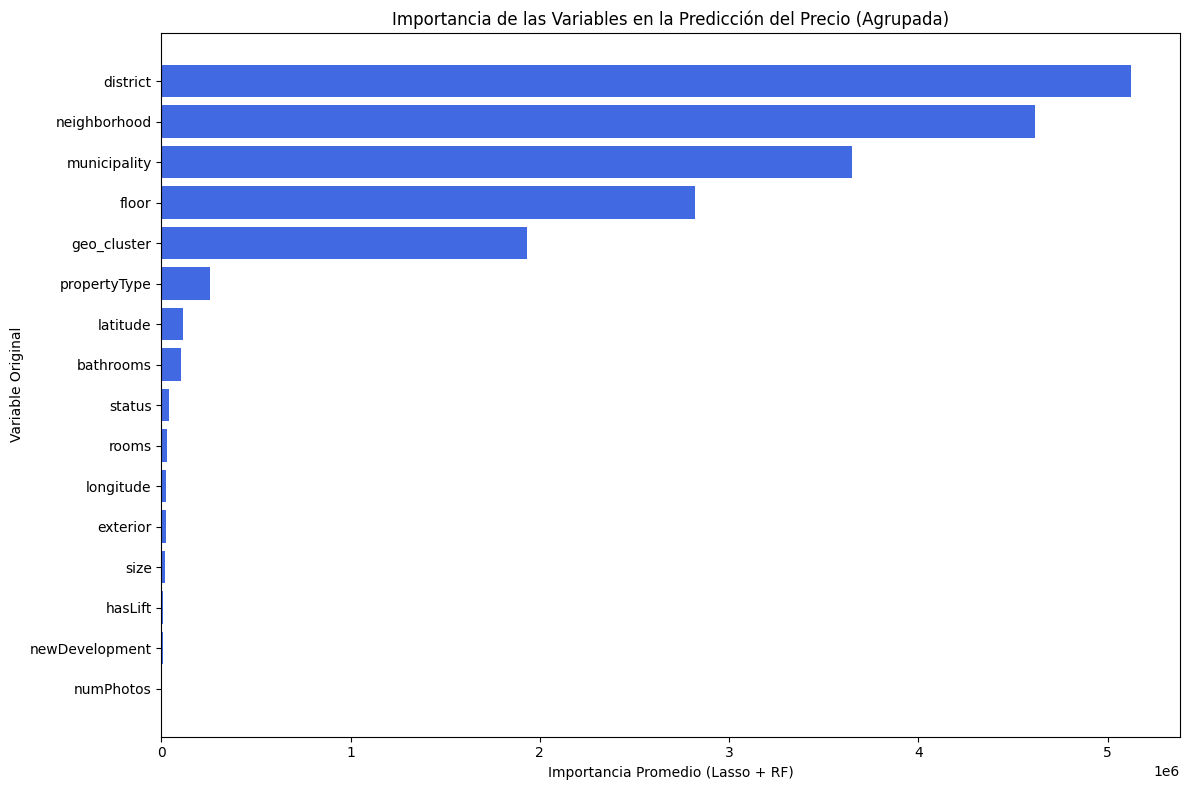


🔄 Evaluando el mejor modelo RF con Cross-Validation en datos de entrenamiento...
Validación Cruzada completada en 154.28 segundos.
📈 R² medio en CV (Entrenamiento - RF): 0.7694 +/- 0.0873
📉 RMSE medio en CV (Entrenamiento - RF): 260962.42 +/- 99747.94

📊 Generando Curvas de Aprendizaje...
Cálculo de Curvas de Aprendizaje completado en 341.68 segundos.


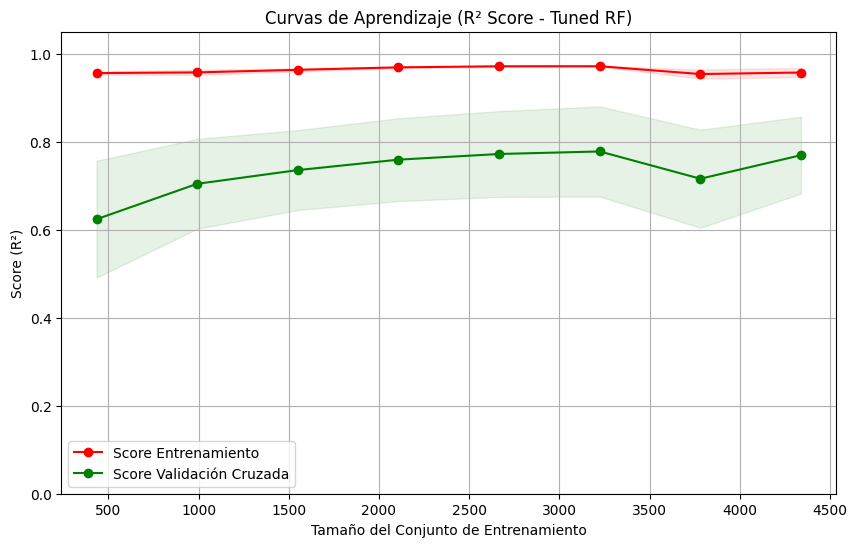


📦 Generando Boxplot de Scores de Validación Cruzada por Fold...


<ipython-input-11-a73136160660>:214: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Fold', y='R2_Score', data=cv_results_df, palette='viridis')


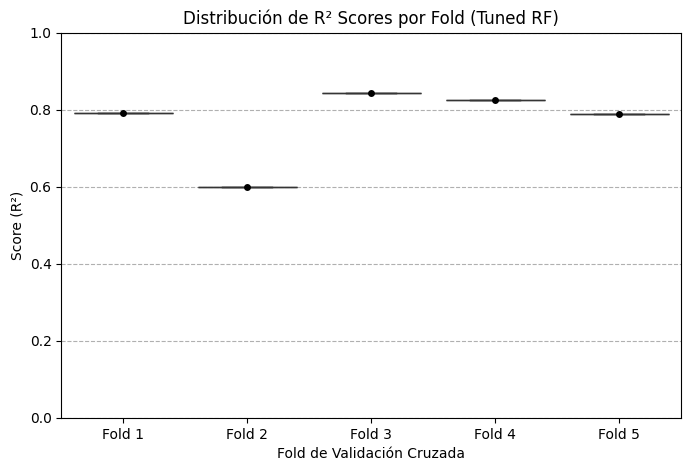


⚡ Realizando predicciones finales en conjuntos de Test y Extrapolación con RF tuneado...

📊 Métricas de Evaluación Finales (Random Forest Tuneado con Cluster Geográfico):
🔹 Test (Interpolación): MAE = 84363.70, RMSE = 194322.13, R² = 0.8665
🔹 Extrapolación:        MAE = 89757.20, RMSE = 219317.72, R² = 0.8062


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint
import seaborn as sns
import time # Para medir tiempo

# --- START: Preprocessing Final (Scaling & OHE) ---
print("\n⚙️ Iniciando Preprocesamiento Final (Escalado y One-Hot Encoding)...")

# 1️⃣ Definir columnas numéricas y categóricas FINALES
#    Excluimos lat/lon de numerical_cols_final si ya se usaron para clustering
#    y no se quieren usar directamente en el modelo, o mantenerlas si se quiere.
#    Aquí las mantenemos por si aportan algo además del cluster.
numerical_cols_final = ["size", "rooms", "bathrooms", "latitude", "longitude", "numPhotos"]
categorical_cols_final = [
    "propertyType", "operation", "floor", "exterior", "province", "municipality",
    "district", "neighborhood", "status", "hasLift", "newDevelopment",
    "geo_cluster" # <--- Incluir el cluster geográfico
]
# Para la agrupación de importancia
categorical_original = categorical_cols_final.copy()

# 2️⃣ Escalar las variables numéricas FINALES
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train[numerical_cols_final])
X_test_num_scaled = scaler.transform(X_test[numerical_cols_final])
X_extrapolation_num_scaled = scaler.transform(X_extrapolation[numerical_cols_final])

# Convertir a DataFrame para facilitar concatenación
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, index=X_train.index, columns=numerical_cols_final)
X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, index=X_test.index, columns=numerical_cols_final)
X_extrapolation_num_scaled_df = pd.DataFrame(X_extrapolation_num_scaled, index=X_extrapolation.index, columns=numerical_cols_final)


# 3️⃣ Aplicar One-Hot Encoding a variables categóricas FINALES
#    Asegurarse de que todas las columnas categóricas sean string
for col in categorical_cols_final:
     X_train[col] = X_train[col].astype(str)
     X_test[col] = X_test[col].astype(str)
     X_extrapolation[col] = X_extrapolation[col].astype(str)

X_train_cat_ohe = pd.get_dummies(X_train[categorical_cols_final], drop_first=True, dtype=int)
# Alinear columnas OHE entre train, test y extrapolation
X_test_cat_ohe = pd.get_dummies(X_test[categorical_cols_final], drop_first=True, dtype=int)
X_extrapolation_cat_ohe = pd.get_dummies(X_extrapolation[categorical_cols_final], drop_first=True, dtype=int)

# Alinear columnas OHE (importante si alguna categoría solo aparece en test/extrapolation o viceversa)
common_cols = X_train_cat_ohe.columns.intersection(X_test_cat_ohe.columns).intersection(X_extrapolation_cat_ohe.columns)
X_train_cat_ohe = X_train_cat_ohe[common_cols]
X_test_cat_ohe = X_test_cat_ohe.reindex(columns=common_cols, fill_value=0)
X_extrapolation_cat_ohe = X_extrapolation_cat_ohe.reindex(columns=common_cols, fill_value=0)

# 4️⃣ Combinar características procesadas
X_train_processed = pd.concat([X_train_num_scaled_df, X_train_cat_ohe], axis=1)
X_test_processed = pd.concat([X_test_num_scaled_df, X_test_cat_ohe], axis=1)
X_extrapolation_processed = pd.concat([X_extrapolation_num_scaled_df, X_extrapolation_cat_ohe], axis=1)

print(f"Dimensiones finales: Train={X_train_processed.shape}, Test={X_test_processed.shape}, Extrapolation={X_extrapolation_processed.shape}")
print("✅ Preprocesamiento Final Completado.")
# --- END: Preprocessing Final ---


# --- START: Model Training & Evaluation ---

# 5️⃣ Aplicar regularización con Lasso para Feature Importance (Part 1)
print("\n🔥 Calculando importancia con Lasso...")
lasso = Lasso(alpha=0.1, max_iter=5000, random_state=42) # Aumentar max_iter
try:
    lasso.fit(X_train_processed, y_train)
    lasso_importance = np.abs(lasso.coef_)
    print("Importancia Lasso calculada.")
except Exception as e:
    print(f"Error en Lasso: {e}. Se usará importancia cero.")
    lasso_importance = np.zeros(X_train_processed.shape[1])


# 6️⃣ Hyperparameter Tuning para Random Forest (usar resultados si ya se hizo, o re-ejecutar)
#    Si ya tienes los mejores parámetros, puedes definirlos directamente.
#    Si no, descomenta y ejecuta la búsqueda.
print("\n⏳ Iniciando Búsqueda de Hiperparámetros para Random Forest...")
start_time_tuning = time.time()

param_dist_rf = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(randint(10, 50).rvs(5)),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 0.5]
}
rf_base = RandomForestRegressor(random_state=42)
random_search_rf = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist_rf,
    n_iter=50, # Reducir n_iter si tarda mucho, aumentar para mejor búsqueda
    cv=5,
    scoring='r2',
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search_rf.fit(X_train_processed, y_train) # USAR DATOS PROCESADOS
best_rf_model = random_search_rf.best_estimator_

end_time_tuning = time.time()
print(f"\nBúsqueda de Hiperparámetros completada en {end_time_tuning - start_time_tuning:.2f} segundos.")
print(f"🏆 Mejores Hiperparámetros encontrados (RF): {random_search_rf.best_params_}")
print(f"🏅 Mejor R² score en CV durante la búsqueda (RF): {random_search_rf.best_score_:.4f}")


# 7️⃣ Calcular importancia de características con el mejor modelo RF.
print("\n🔥 Calculando importancia con Random Forest (tuneado)...")
rf_importance = best_rf_model.feature_importances_

# 8️⃣ Combinar y agrupar importancias (Lasso + RF)
print("\n📊 Agrupando Importancia de Características...")
feature_importance_df = pd.DataFrame({
    "Feature": X_train_processed.columns, # Usar columnas procesadas
    "Lasso Importance": lasso_importance,
    "Random Forest Importance": rf_importance
})
feature_importance_df["Mean Importance"] = (
    feature_importance_df["Lasso Importance"] + feature_importance_df["Random Forest Importance"]
) / 2

# Agrupar (la lógica de agrupación necesita adaptarse a nombres OHE)
feature_importance_grouped = {}
for feature, importance in zip(feature_importance_df["Feature"], feature_importance_df["Mean Importance"]):
    # Identificar la característica original (antes de OHE o escalado)
    original_feature = feature
    is_categorical_ohe = False
    for cat_orig in categorical_original:
        if feature.startswith(cat_orig + "_"):
             original_feature = cat_orig
             is_categorical_ohe = True
             break # Encontrada la base categórica

    if original_feature in categorical_original and is_categorical_ohe:
        # Sumar importancia para las categóricas OHE
        feature_importance_grouped[original_feature] = feature_importance_grouped.get(original_feature, 0) + importance
    elif original_feature in numerical_cols_final:
         # Asignar importancia directamente para numéricas (ya escaladas, nombre coincide)
         feature_importance_grouped[original_feature] = feature_importance_grouped.get(original_feature, importance) # Usar get para evitar sobreescribir si hay OHE con mismo prefijo
    # else: Podrías manejar otros casos si es necesario

# Convertir a DataFrame ordenado
feature_importance_grouped_df = pd.DataFrame(
    list(feature_importance_grouped.items()), columns=["Feature", "Importance"]
).sort_values(by="Importance", ascending=False)

# 9️⃣ Mostrar y graficar importancia agrupada
print("\n📊 Importancia de las Variables (Agrupadas por Categoría - Lasso + Tuned RF):")
print(feature_importance_grouped_df)
plt.figure(figsize=(12,8)) # Aumentar tamaño si hay muchas features
plt.barh(feature_importance_grouped_df["Feature"], feature_importance_grouped_df["Importance"], color='royalblue')
plt.xlabel("Importancia Promedio (Lasso + RF)")
plt.ylabel("Variable Original")
plt.title("Importancia de las Variables en la Predicción del Precio (Agrupada)")
plt.gca().invert_yaxis()
plt.tight_layout() # Ajustar layout
plt.show()


# 🔟 Evaluar el MEJOR modelo RF usando Cross-Validation en el conjunto de entrenamiento
print("\n🔄 Evaluando el mejor modelo RF con Cross-Validation en datos de entrenamiento...")
start_time_cv = time.time()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_r2 = cross_val_score(best_rf_model, X_train_processed, y_train, cv=kf, scoring='r2', n_jobs=-1)
cv_scores_neg_mse = cross_val_score(best_rf_model, X_train_processed, y_train, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
cv_scores_rmse = np.sqrt(-cv_scores_neg_mse)
end_time_cv = time.time()
print(f"Validación Cruzada completada en {end_time_cv - start_time_cv:.2f} segundos.")
print(f"📈 R² medio en CV (Entrenamiento - RF): {np.mean(cv_scores_r2):.4f} +/- {np.std(cv_scores_r2):.4f}")
print(f"📉 RMSE medio en CV (Entrenamiento - RF): {np.mean(cv_scores_rmse):.2f} +/- {np.std(cv_scores_rmse):.2f}")

# 1️⃣1️⃣ Gráfica: Curvas de Aprendizaje
print("\n📊 Generando Curvas de Aprendizaje...")
start_time_lc = time.time()
train_sizes_abs, train_scores, validation_scores = learning_curve(
    estimator=best_rf_model,
    X=X_train_processed, y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 8), # Reducir puntos si tarda mucho
    cv=kf, scoring='r2', n_jobs=-1, random_state=42
)
end_time_lc = time.time()
print(f"Cálculo de Curvas de Aprendizaje completado en {end_time_lc - start_time_lc:.2f} segundos.")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes_abs, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label="Score Entrenamiento")
plt.plot(train_sizes_abs, validation_scores_mean, 'o-', color="g", label="Score Validación Cruzada")
plt.title("Curvas de Aprendizaje (R² Score - Tuned RF)")
plt.xlabel("Tamaño del Conjunto de Entrenamiento")
plt.ylabel("Score (R²)")
plt.legend(loc="best"); plt.grid(True); plt.ylim(0, 1.05); plt.show()


# 1️⃣2️⃣ Gráfica: Boxplot de Scores por Fold
print("\n📦 Generando Boxplot de Scores de Validación Cruzada por Fold...")
cv_results_df = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(cv_scores_r2))],
    'R2_Score': cv_scores_r2
})
plt.figure(figsize=(8, 5))
sns.boxplot(x='Fold', y='R2_Score', data=cv_results_df, palette='viridis')
sns.stripplot(x='Fold', y='R2_Score', data=cv_results_df, color='black', jitter=0.1, size=5)
plt.title('Distribución de R² Scores por Fold (Tuned RF)')
plt.xlabel("Fold de Validación Cruzada"); plt.ylabel("Score (R²)");
plt.ylim(min(0, cv_scores_r2.min() - 0.05), 1.0); plt.grid(axis='y', linestyle='--'); plt.show()


# 1️⃣3️⃣ Predicciones y Evaluación Final (usando el MEJOR modelo RF)
print("\n⚡ Realizando predicciones finales en conjuntos de Test y Extrapolación con RF tuneado...")
y_test_pred = best_rf_model.predict(X_test_processed)
y_extrapolation_pred = best_rf_model.predict(X_extrapolation_processed)

# Métricas para conjunto de test (Interpolación)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Métricas para conjunto de extrapolación
mae_extra = mean_absolute_error(y_extrapolation, y_extrapolation_pred)
mse_extra = mean_squared_error(y_extrapolation, y_extrapolation_pred)
rmse_extra = np.sqrt(mse_extra)
r2_extra = r2_score(y_extrapolation, y_extrapolation_pred)

# Imprimir resultados finales
print("\n📊 Métricas de Evaluación Finales (Random Forest Tuneado con Cluster Geográfico):")
print(f"🔹 Test (Interpolación): MAE = {mae_test:.2f}, RMSE = {rmse_test:.2f}, R² = {r2_test:.4f}")
print(f"🔹 Extrapolación:        MAE = {mae_extra:.2f}, RMSE = {rmse_extra:.2f}, R² = {r2_extra:.4f}")

# --- END: Model Training & Evaluation ---

LightGBM


⚙️ Iniciando Preprocesamiento Final (Escalado y One-Hot Encoding)...
Dimensiones finales: Train=(5425, 239), Test=(1357, 239), Extrapolation=(1696, 239)
✅ Preprocesamiento Final Completado.

🔥 Calculando importancia con Lasso...
Importancia Lasso calculada.

⏳ Iniciando Búsqueda de Hiperparámetros para LightGBM...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.277e+14, tolerance: 1.612e+11
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1305
[LightGBM] [Info] Number of data points in the train set: 5425, number of used features: 222
[LightGBM] [Info] Start training from score 468444.117788

Búsqueda de Hiperparámetros (LGBM) completada en 3994.77 segundos.
🏆 Mejores Hiperparámetros encontrados (LGBM): {'colsample_bytree': np.float64(0.713936197750987), 'learning_rate': np.float64(0.01553304210317992), 'max_depth': -1, 'min_child_samples': 6, 'n_estimators': 741, 'num_leaves': 47, 'reg_alpha': np.float64(0.05147875124998935), 'reg_lambda': np.float64(0.27864646423661144), 'subsample': np.float64(0.9633063543866615)}
🏅 Mejor R² score en CV durante la búsqueda (LGBM): 0.7911

🔥 Calculando importancia con LightGBM (tuneado)...

📊 Agrupando Importancia de C

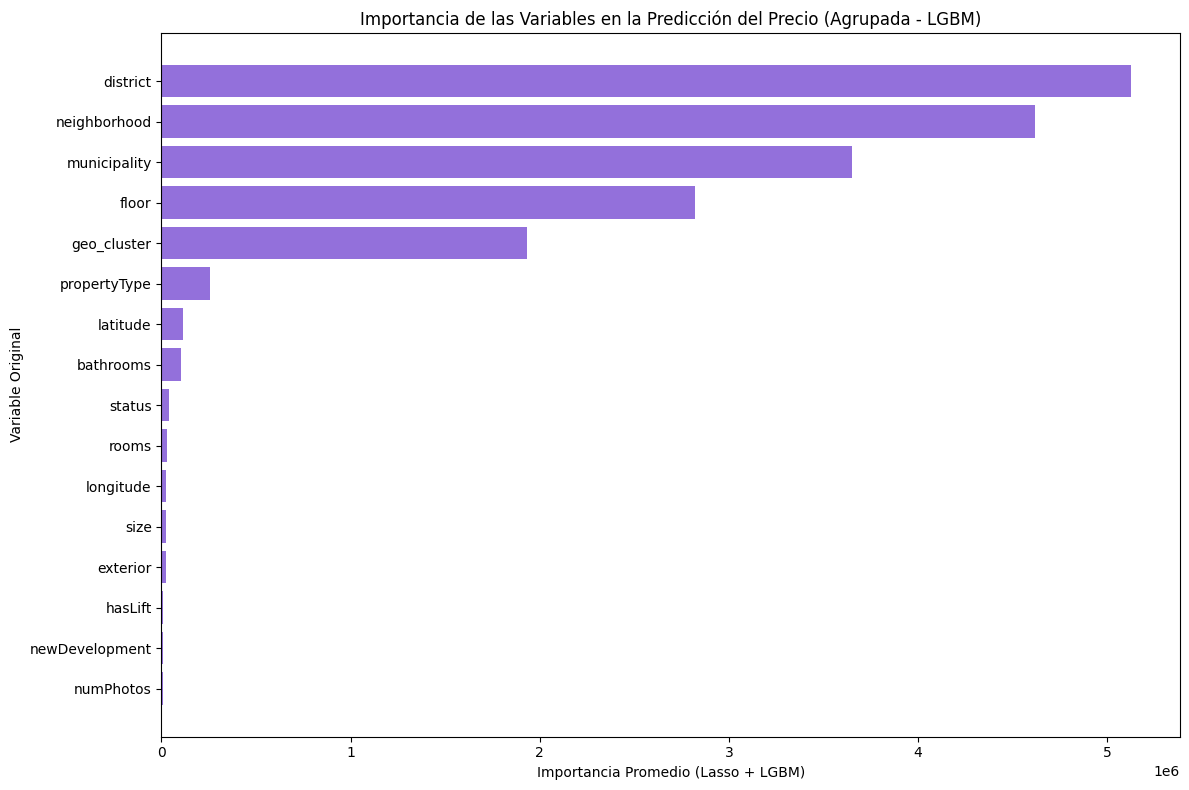


🔄 Evaluando el mejor modelo LGBM con Cross-Validation en datos de entrenamiento...
Validación Cruzada (LGBM) completada en 92.55 segundos.
📈 R² medio en CV (Entrenamiento - LGBM): 0.7565 +/- 0.0935
📉 RMSE medio en CV (Entrenamiento - LGBM): 268752.94 +/- 104412.47

📊 Generando Curvas de Aprendizaje (LGBM)...
Cálculo de Curvas de Aprendizaje (LGBM) completado en 424.43 segundos.


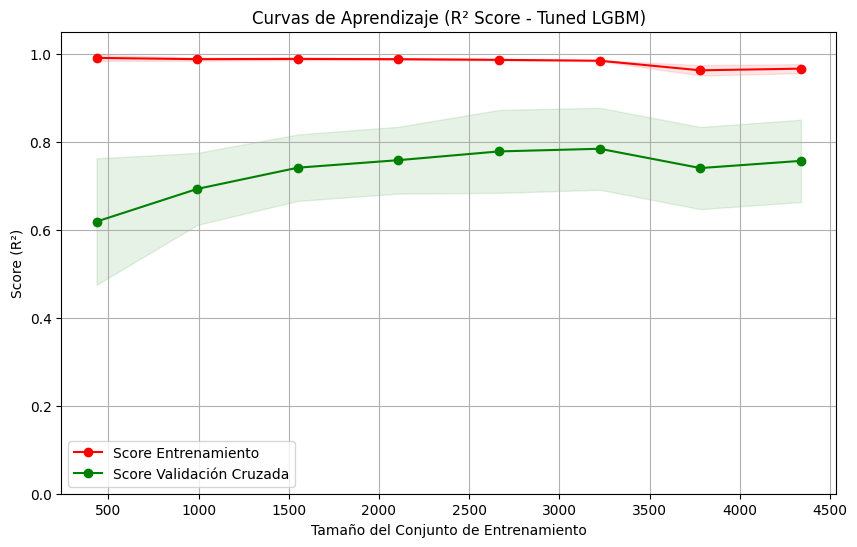


📦 Generando Boxplot de Scores de Validación Cruzada por Fold (LGBM)...


<ipython-input-12-677785de13a7>:200: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Fold', y='R2_Score', data=cv_results_df_lgbm, palette='magma') # <-- Cambiado paleta y datos


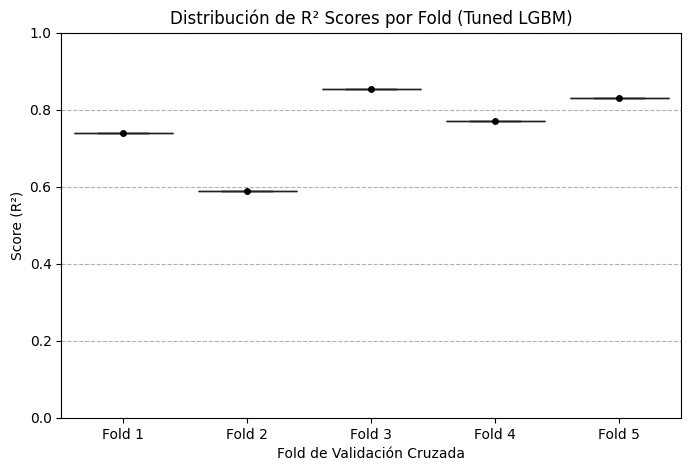


⚡ Realizando predicciones finales en conjuntos de Test y Extrapolación con LGBM tuneado...

📊 Métricas de Evaluación Finales (LightGBM Tuneado con Cluster Geográfico):
🔹 Test (Interpolación): MAE = 91574.08, RMSE = 206413.75, R² = 0.8494
🔹 Extrapolación:        MAE = 93716.41, RMSE = 221287.28, R² = 0.8027


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
# from sklearn.ensemble import RandomForestRegressor # No longer needed
import lightgbm as lgb # <-- Import LightGBM
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint, uniform
import seaborn as sns
import time

# --- START: Preprocessing Final (Scaling & OHE) ---
# (Esta sección es idéntica a la versión anterior con RF/XGBoost,
# asegurándose de que X_train_processed, X_test_processed, X_extrapolation_processed
# estén listos y contengan la característica 'geo_cluster' si se generó)
print("\n⚙️ Iniciando Preprocesamiento Final (Escalado y One-Hot Encoding)...")

# 1️⃣ Definir columnas numéricas y categóricas FINALES
numerical_cols_final = ["size", "rooms", "bathrooms", "latitude", "longitude", "numPhotos"]
categorical_cols_final = [
    "propertyType", "operation", "floor", "exterior", "province", "municipality",
    "district", "neighborhood", "status", "hasLift", "newDevelopment",
    "geo_cluster" # Asumiendo que se generó en la celda anterior
]
categorical_original = categorical_cols_final.copy()

# 2️⃣ Escalar las variables numéricas FINALES
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train[numerical_cols_final])
X_test_num_scaled = scaler.transform(X_test[numerical_cols_final])
X_extrapolation_num_scaled = scaler.transform(X_extrapolation[numerical_cols_final])
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, index=X_train.index, columns=numerical_cols_final)
X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, index=X_test.index, columns=numerical_cols_final)
X_extrapolation_num_scaled_df = pd.DataFrame(X_extrapolation_num_scaled, index=X_extrapolation.index, columns=numerical_cols_final)

# 3️⃣ Aplicar One-Hot Encoding a variables categóricas FINALES
for col in categorical_cols_final:
     X_train[col] = X_train[col].astype(str)
     X_test[col] = X_test[col].astype(str)
     X_extrapolation[col] = X_extrapolation[col].astype(str)
X_train_cat_ohe = pd.get_dummies(X_train[categorical_cols_final], drop_first=True, dtype=int)
X_test_cat_ohe = pd.get_dummies(X_test[categorical_cols_final], drop_first=True, dtype=int)
X_extrapolation_cat_ohe = pd.get_dummies(X_extrapolation[categorical_cols_final], drop_first=True, dtype=int)
common_cols = X_train_cat_ohe.columns.intersection(X_test_cat_ohe.columns).intersection(X_extrapolation_cat_ohe.columns)
X_train_cat_ohe = X_train_cat_ohe[common_cols]
X_test_cat_ohe = X_test_cat_ohe.reindex(columns=common_cols, fill_value=0)
X_extrapolation_cat_ohe = X_extrapolation_cat_ohe.reindex(columns=common_cols, fill_value=0)

# 4️⃣ Combinar características procesadas
X_train_processed = pd.concat([X_train_num_scaled_df, X_train_cat_ohe], axis=1)
X_test_processed = pd.concat([X_test_num_scaled_df, X_test_cat_ohe], axis=1)
X_extrapolation_processed = pd.concat([X_extrapolation_num_scaled_df, X_extrapolation_cat_ohe], axis=1)

print(f"Dimensiones finales: Train={X_train_processed.shape}, Test={X_test_processed.shape}, Extrapolation={X_extrapolation_processed.shape}")
print("✅ Preprocesamiento Final Completado.")
# --- END: Preprocessing Final ---


# --- START: Model Training & Evaluation (LightGBM) ---

# 5️⃣ Aplicar regularización con Lasso para Feature Importance (Part 1)
# (Idéntico a antes)
print("\n🔥 Calculando importancia con Lasso...")
lasso = Lasso(alpha=0.1, max_iter=5000, random_state=42)
try:
    lasso.fit(X_train_processed, y_train)
    lasso_importance = np.abs(lasso.coef_)
    print("Importancia Lasso calculada.")
except Exception as e:
    print(f"Error en Lasso: {e}. Se usará importancia cero.")
    lasso_importance = np.zeros(X_train_processed.shape[1])


# 6️⃣ Hyperparameter Tuning para LightGBM
print("\n⏳ Iniciando Búsqueda de Hiperparámetros para LightGBM...")
start_time_tuning = time.time()

param_dist_lgbm = {
    'n_estimators': randint(100, 1500), # Número de árboles
    'learning_rate': uniform(0.01, 0.15), # Tasa de aprendizaje
    'num_leaves': randint(20, 60), # Número de hojas (controla complejidad)
    'max_depth': [-1] + list(randint(5, 15).rvs(3)), # Profundidad máxima (-1 sin límite)
    'subsample': uniform(0.6, 0.4), # Fracción de muestras por árbol (bagging_fraction)
    'colsample_bytree': uniform(0.6, 0.4), # Fracción de features por árbol (feature_fraction)
    'reg_alpha': uniform(0, 1), # L1 regularization
    'reg_lambda': uniform(0, 1), # L2 regularization
    'min_child_samples': randint(5, 30) # Mínimo de muestras en hoja
}

lgbm_base = lgb.LGBMRegressor(objective='regression', # o 'regression_l1' para MAE
                              random_state=42,
                              n_jobs=-1)

random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_base,
    param_distributions=param_dist_lgbm,
    n_iter=100,  # Probar 100 combinaciones (ajustar si es necesario)
    cv=5,
    scoring='r2',
    verbose=1,
    random_state=42,
    n_jobs=-1 # Usar todos los cores para CV
)

random_search_lgbm.fit(X_train_processed, y_train) # USAR DATOS PROCESADOS
best_lgbm_model = random_search_lgbm.best_estimator_

end_time_tuning = time.time()
print(f"\nBúsqueda de Hiperparámetros (LGBM) completada en {end_time_tuning - start_time_tuning:.2f} segundos.")
print(f"🏆 Mejores Hiperparámetros encontrados (LGBM): {random_search_lgbm.best_params_}")
print(f"🏅 Mejor R² score en CV durante la búsqueda (LGBM): {random_search_lgbm.best_score_:.4f}")


# 7️⃣ Calcular importancia de características con el mejor modelo LGBM.
print("\n🔥 Calculando importancia con LightGBM (tuneado)...")
lgbm_importance = best_lgbm_model.feature_importances_

# 8️⃣ Combinar y agrupar importancias (Lasso + LGBM)
print("\n📊 Agrupando Importancia de Características...")
feature_importance_df = pd.DataFrame({
    "Feature": X_train_processed.columns,
    "Lasso Importance": lasso_importance,
    "LightGBM Importance": lgbm_importance # <-- Cambiado
})
feature_importance_df["Mean Importance"] = (
    feature_importance_df["Lasso Importance"] + feature_importance_df["LightGBM Importance"]
) / 2

# Agrupar (la lógica de agrupación es la misma)
feature_importance_grouped = {}
for feature, importance in zip(feature_importance_df["Feature"], feature_importance_df["Mean Importance"]):
    original_feature = feature; is_categorical_ohe = False
    for cat_orig in categorical_original:
        if feature.startswith(cat_orig + "_"):
             original_feature = cat_orig; is_categorical_ohe = True; break
    if original_feature in categorical_original and is_categorical_ohe:
        feature_importance_grouped[original_feature] = feature_importance_grouped.get(original_feature, 0) + importance
    elif original_feature in numerical_cols_final:
         feature_importance_grouped[original_feature] = feature_importance_grouped.get(original_feature, importance)
feature_importance_grouped_df = pd.DataFrame(
    list(feature_importance_grouped.items()), columns=["Feature", "Importance"]
).sort_values(by="Importance", ascending=False)

# 9️⃣ Mostrar y graficar importancia agrupada
print("\n📊 Importancia de las Variables (Agrupadas por Categoría - Lasso + Tuned LGBM):") # <-- Cambiado
print(feature_importance_grouped_df)
plt.figure(figsize=(12,8))
plt.barh(feature_importance_grouped_df["Feature"], feature_importance_grouped_df["Importance"], color='mediumpurple') # <-- Cambiado color
plt.xlabel("Importancia Promedio (Lasso + LGBM)") # <-- Cambiado
plt.ylabel("Variable Original")
plt.title("Importancia de las Variables en la Predicción del Precio (Agrupada - LGBM)") # <-- Cambiado
plt.gca().invert_yaxis()
plt.tight_layout(); plt.show()


# 🔟 Evaluar el MEJOR modelo LGBM usando Cross-Validation en el conjunto de entrenamiento
print("\n🔄 Evaluando el mejor modelo LGBM con Cross-Validation en datos de entrenamiento...")
start_time_cv = time.time()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_r2_lgbm = cross_val_score(best_lgbm_model, X_train_processed, y_train, cv=kf, scoring='r2', n_jobs=-1) # <-- Cambiado
cv_scores_neg_mse_lgbm = cross_val_score(best_lgbm_model, X_train_processed, y_train, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1) # <-- Cambiado
cv_scores_rmse_lgbm = np.sqrt(-cv_scores_neg_mse_lgbm) # <-- Cambiado
end_time_cv = time.time()
print(f"Validación Cruzada (LGBM) completada en {end_time_cv - start_time_cv:.2f} segundos.")
print(f"📈 R² medio en CV (Entrenamiento - LGBM): {np.mean(cv_scores_r2_lgbm):.4f} +/- {np.std(cv_scores_r2_lgbm):.4f}") # <-- Cambiado
print(f"📉 RMSE medio en CV (Entrenamiento - LGBM): {np.mean(cv_scores_rmse_lgbm):.2f} +/- {np.std(cv_scores_rmse_lgbm):.2f}") # <-- Cambiado

# 1️⃣1️⃣ Gráfica: Curvas de Aprendizaje (LGBM)
print("\n📊 Generando Curvas de Aprendizaje (LGBM)...")
start_time_lc = time.time()
train_sizes_abs, train_scores, validation_scores = learning_curve(
    estimator=best_lgbm_model, # <-- Cambiado
    X=X_train_processed, y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv=kf, scoring='r2', n_jobs=-1, random_state=42
)
end_time_lc = time.time()
print(f"Cálculo de Curvas de Aprendizaje (LGBM) completado en {end_time_lc - start_time_lc:.2f} segundos.")
train_scores_mean = np.mean(train_scores, axis=1); train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1); validation_scores_std = np.std(validation_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes_abs, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label="Score Entrenamiento")
plt.plot(train_sizes_abs, validation_scores_mean, 'o-', color="g", label="Score Validación Cruzada")
plt.title("Curvas de Aprendizaje (R² Score - Tuned LGBM)") # <-- Cambiado
plt.xlabel("Tamaño del Conjunto de Entrenamiento"); plt.ylabel("Score (R²)");
plt.legend(loc="best"); plt.grid(True); plt.ylim(0, 1.05); plt.show()


# 1️⃣2️⃣ Gráfica: Boxplot de Scores por Fold (LGBM)
print("\n📦 Generando Boxplot de Scores de Validación Cruzada por Fold (LGBM)...")
cv_results_df_lgbm = pd.DataFrame({ # <-- Cambiado
    'Fold': [f'Fold {i+1}' for i in range(len(cv_scores_r2_lgbm))], # <-- Cambiado
    'R2_Score': cv_scores_r2_lgbm # <-- Cambiado
})
plt.figure(figsize=(8, 5))
sns.boxplot(x='Fold', y='R2_Score', data=cv_results_df_lgbm, palette='magma') # <-- Cambiado paleta y datos
sns.stripplot(x='Fold', y='R2_Score', data=cv_results_df_lgbm, color='black', jitter=0.1, size=5) # <-- Cambiado datos
plt.title('Distribución de R² Scores por Fold (Tuned LGBM)') # <-- Cambiado
plt.xlabel("Fold de Validación Cruzada"); plt.ylabel("Score (R²)");
plt.ylim(min(0, cv_scores_r2_lgbm.min() - 0.05), 1.0); plt.grid(axis='y', linestyle='--'); plt.show() # <-- Cambiado


# 1️⃣3️⃣ Predicciones y Evaluación Final (usando el MEJOR modelo LGBM)
print("\n⚡ Realizando predicciones finales en conjuntos de Test y Extrapolación con LGBM tuneado...")
y_test_pred_lgbm = best_lgbm_model.predict(X_test_processed) # <-- Cambiado
y_extrapolation_pred_lgbm = best_lgbm_model.predict(X_extrapolation_processed) # <-- Cambiado

# Métricas para conjunto de test (Interpolación)
mae_test_lgbm = mean_absolute_error(y_test, y_test_pred_lgbm) # <-- Cambiado
mse_test_lgbm = mean_squared_error(y_test, y_test_pred_lgbm) # <-- Cambiado
rmse_test_lgbm = np.sqrt(mse_test_lgbm) # <-- Cambiado
r2_test_lgbm = r2_score(y_test, y_test_pred_lgbm) # <-- Cambiado

# Métricas para conjunto de extrapolación
mae_extra_lgbm = mean_absolute_error(y_extrapolation, y_extrapolation_pred_lgbm) # <-- Cambiado
mse_extra_lgbm = mean_squared_error(y_extrapolation, y_extrapolation_pred_lgbm) # <-- Cambiado
rmse_extra_lgbm = np.sqrt(mse_extra_lgbm) # <-- Cambiado
r2_extra_lgbm = r2_score(y_extrapolation, y_extrapolation_pred_lgbm) # <-- Cambiado

# Imprimir resultados finales
print("\n📊 Métricas de Evaluación Finales (LightGBM Tuneado con Cluster Geográfico):") # <-- Cambiado
print(f"🔹 Test (Interpolación): MAE = {mae_test_lgbm:.2f}, RMSE = {rmse_test_lgbm:.2f}, R² = {r2_test_lgbm:.4f}") # <-- Cambiado
print(f"🔹 Extrapolación:        MAE = {mae_extra_lgbm:.2f}, RMSE = {rmse_extra_lgbm:.2f}, R² = {r2_extra_lgbm:.4f}") # <-- Cambiado

# --- END: Model Training & Evaluation (LightGBM) ---

Catboost

In [8]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.8 MB/s eta 0:00:00
